# ASTR3110 Tutorial 4: MCMC

Tutorial 4 of the *'Data Science Techniques in Astrophysics'* course at Macquarie University.

## Learning outcomes from this tutorial

 * Understand what a sampler achieves
 * Understand the terms in Bayes's Formula and how they relate to fitting models
 * Use a MCMC sampler to fit a polynomial model to a simple 1D spectrum
 * Create a triangle plot to show correlations between parameters
 * Extract best-fit and uncertainty estimates from an MCMC chain


## Likelihood, Priors and Bayes's Theorem

In Tutorial 3 we used $\chi^2_{\rm model}$ difference between the model and data as a measure of *goodness of fit* and found the best-fitting model by minimizing its value. However, we often have *prior* independent measurements of the parameters we want to fit. We want this prior information to weight the total $\chi^2$ value so that it prefers parameter values closer to our previous measurements. Each prior parameter estimate contributes its own $\chi^2$ value. For example, for a parameter $p = p_{\rm prior} \pm \sigma_{\rm prior}$, the $\chi^2_{\rm prior}$ value is given by:

$$\chi^2_{\rm prior} = \left(\frac{p_{\rm model} - p_{\rm prior}}{\sigma_{\rm prior}}\right)^2$$.

The total $\chi^2$ value is then given by the sum of all values: $\chi^2 = \chi^2_{\rm model} + \chi^2_{\rm prior}$.

The *likelihood* is a related way of assessing a model fit: *what is the probability, or likelhood $\mathcal{L}$, of getting the observed data given particular values of parameters p?* For Gaussian distributed likelihoods the likelihood is related to $\chi^2$ via

$$\mathcal{L} = exp(-\chi^2\big/2)~~~~or~~~~-2~{\rm ln}(\mathcal{L}) = \chi^2,$$

so that $\chi^2$ is often referred to as the 'log-likelihood'. Because $\mathcal{L}$ is in log-space, likelihoods are *multiplied* to get the total $\mathcal{L}$. From a numerical perspective, the log-likelihood is also a smaller number and less likely to run into computational limits.

### Bayes's Theorem

For a model hypothesis $\mathcal{M}$
and data $\boldsymbol{d}$, the posterior probability for a set of
model parameters $\boldsymbol{\theta}$ is given by Bayes' Theorem
\begin{equation}\label{eqn:bayes_formula}
  {\rm Pr}(\boldsymbol{\theta}|\boldsymbol{d}, \mathcal{M}) =
  \frac{{\rm Pr}(\boldsymbol{d}|\boldsymbol{\theta},
    \mathcal{M})\,{\rm Pr}(\boldsymbol{\theta}|\mathcal{M})}
       {{\rm Pr}(\boldsymbol{d}|\mathcal{M})}.
\end{equation}
The term ${\rm Pr}(\boldsymbol{d}|\boldsymbol{\theta}, \mathcal{M})$
is the probability of the data given the model parameters, also known
as the likelihood $\mathcal{L}$.  The term ${\rm Pr}(\boldsymbol{\theta}|\mathcal{M})$ is known as the
prior; it encodes the probability of the
current parameter values given the proposed model, i.e., any  *a
  priori* information about the values. The final term ${\rm Pr}(\boldsymbol{d}|\mathcal{M})$, known as the
evidence, is the probability of the data given the model and serves to
normalise the posterior distribution so that the total probability is
unity.

I found the discussion by Adrian Price-Whelan of the Flatiron Institute to be very helpful for understanding the above: [see this link](https://adrian.pw/blog/fitting-a-line/).

In [1]:
#In the way that we fitted data last week, we determined a single set of parameters that best described the data. We 
#can also determine the proability, or likelihood, of getting those data given the model parameters.

#The bayesian way of thinking is to try to understand what is the posterior probability distribution of the 
#model parameters given the data and our prior knowledge of any parameter values. 

# To map this out, we use MCMC samplers to randomly
#"fill out" the posterior probability space and to return percentiles for the parameter distributions. These give our 
#best fit "most probable" parameter estimates and their associated uncertainty.

#this is really important for when the likelihood distributions become complicated.

## The MCMC Sampler

## Setup for Google Drive and data access

As with the tutorial last week, we will be operating on actual data, so please mount your Google Drive:

In [2]:
# Comment out if running locally
#from google.colab import drive
#drive.mount('/content/gdrive')

In [3]:
# Get into the correct directory (replace with the location of your copy)
#cd "gdrive/"My Drive"/ASTR3110_Tutorial_Notebooks 

We will be processing the same polarised radio-wavelength spectrum as last week. If you haven't already downloaded it, you can get it from this link: [HotSpot.csv](https://github.com/MQ-ASTR3110/ASTR3110_Tutorial_Notebooks_2022/blob/master/DATA/HotSpot.csv). Save this file to your Google Drive under, for example, your 'DATA/' directory.

As a reminder, the file contains 7 columns corresponding to:

[frequency_Hz, I_mJy, Q_mJy, U_mJy, dI_mJy, dQ_mJy, dU_mJy]

We will want to access the columns frequency_Hz, I_mJy (flux in milly Janskys) and dI_mJy (uncertainty in flux). Start by reading all of the file into a Pandas dataframe:

In [4]:
#Same as Tutorial 3
import pandas as pd

# Read all columns into a Pandas dataframe
specDF  = pd.read_csv("DATA/HotSpot.csv")

# Convert Hz to GHz and add column
specDF['frequency_GHz'] = specDF['frequency_Hz']/1e9
print("Array has shape (columns, rows):", specDF.shape)

Array has shape (columns, rows): (198, 8)


As a shortcut, some useful functions are in the file ```Imports/util_tute04.py```. These can be imported into the current notebook like this:

In [5]:
# Import the function to evaluate a polynomial
#Modified to run in solutions directory by symbolically linking Imports dir
from Imports.util_tute04 import polyN

# Import the function to plot the spectrum
from Imports.util_tute04 import plot_spec_polyN

You can examine *code* by using double question-marks to summon help:

In [7]:
# Examine the code for the imported function (show 1 ?, which gives short description vs ??, which gives code.)
polyN?
polyN??
#plot_spec_polyN??

You can see that this is our convenience function from Tutorial 3 for plotting the polynomial data and (optionally) best-fitting model. Use it now to check the data has been read in correctly:

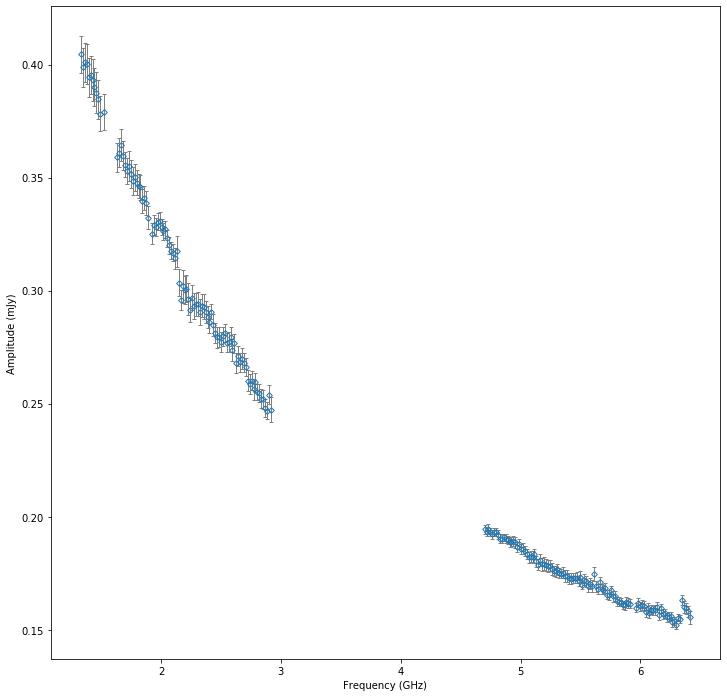

In [8]:
%matplotlib inline

# Set the data arrays from the dataframe
xData = specDF['frequency_GHz'].values
yData = specDF['I_mJy'].values
dyData = specDF['dI_mJy'].values

# Plot the spectrum
plot_spec_polyN(xData, yData, dyData)

## Using MCMC to fit a Polynomial

Here we use the MCMC module ```emcee``` to fit our familiar spectrum using a polynomial model. Using a MCMC sampler has some distinct advantages when it comes to estimating the best-fitting parameters and uncertainty values.

Like before we define a *goodness-of-fit* function. However, this time we formulate it as a log-likelihood:

In [9]:
# Function to calculate the log-likelihood of our model
import numpy as np
def lnlike_model(p, xData, yData, dyData):
    """
    Evaluate log-likelihood given the parameters and data
    """
    
    # Calculate the y values at the given x values and polynomial parametrs p
    yModel = polyN(p,xData)

    # Calculate chi-squared value
    chisqValue = np.sum( ((yModel - yData) / dyData)**2 )
    
    return -chisqValue / 2.

ln(like) = -58.70, chi^2 = 117.40, chi^2_red = 0.61


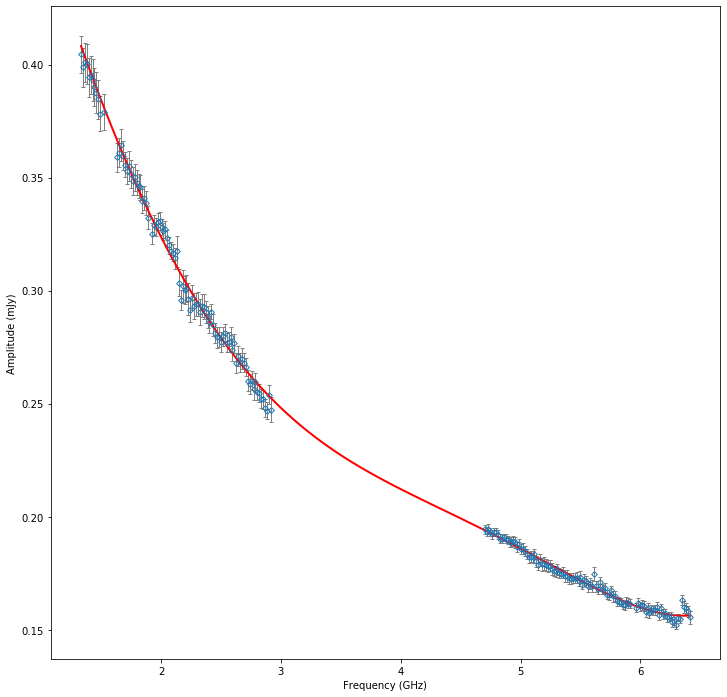

In [10]:
# Check with best fit values from Tutorial 3
#pFit = [ 2.46e-04, -4.07e-03,  2.11e-02,
#        -1.67e-02, -1.8e-01,  6.41e-01] These truncated values give a poor fit!
pFit = [6.40477442e-01, -1.80748818e-01, -1.67180188e-02,  
        2.11088165e-02, -4.06701974e-03,  2.46537547e-04]
lnLikeModel = lnlike_model(pFit, xData, yData, dyData)
chiSq = -2 * lnLikeModel
dof = len(xData) - len(pFit) - 1
chiSqRed = chiSq / dof
print("ln(like) = {:.2f}, chi^2 = {:.2f}, chi^2_red = {:.2f}"
      .format(lnLikeModel, chiSq, chiSqRed))

# Plot the data and fit
plot_spec_polyN(xData, yData, dyData, pFit)

Unlike a gradient-decent method, we are not trying to go directly to a minimum point. Instead we want our guesses to spread out over parameter space *near the best-fit value*. Because the next guess of the chain is weighted by the likelihood, the 'walkers' spend most time near the peak likelihood and less time away from it. The density of samples can be used as a proxy for the posterior likelihood distribution.

For this excercise we will use a module called [emcee](https://emcee.readthedocs.io/en/stable/). This is a pure *Python* implementation of an MCMC sampler that makes many guesses in parallel. You can visualise each guess as a time-series of positions in parameter space that 'walk' all over parameter space - hence we call them 'walkers'.

In [11]:
from Imports import emcee

# Set the sampling parameters
ndim = 6         # Number of parameters -- 6 for our case. Straight line would be 2 parameters.
nWalkers = 100   # How many walkers in parallel? These are used to map out the parameter space.

# To run this, we first define an MCMC sampler object. This just sets up the MCMC parameters for when we are ready 
#to run. Need to tell it how many walkers to use, the dimension (number of parameters), the loglikelihood
#function, the arguments that the loglike takes to evaluate the model,  and the number of processors to
#use on the computer (this can be parallelised to run faster.)

sampler = emcee.EnsembleSampler(nwalkers = nWalkers,
                                dim      = ndim,
                                lnpostfn = lnlike_model,
                                args     = [xData, yData, dyData],
                                threads  = 2)

Now that we have set our sampler parameters we can set it off walking to the answer. We have made no attempt at making a good initial guess, so our walkers will probably take a while to get close to the best fitting region. This is called the burn-in period and you need to visualise the history of each walker to see when they reach the right area of parameter space.

In [12]:
# Run the sampler
nBurnSteps = 1000#Because the initial estimates are not very good, we need to define a number of "Burn in" steps,
#which allow the sampler to converge to a region close to the maximum likelihood. We'll look at how the parameters
#change as the MCMC progresses across the 1000 steps. This is called the "chain" and it gives the history of where the 
#walkers moved during the run. ALSO BE CAREFUL WITH THIS SETTING: TOO LARGE AND IF YOU DON'T HASVE A GOOD COMPUTER IT 
#COULD TAKE A LONG TIME TO RUN!

# Randomly initialise a 2D array of walkers between [-1.5, 1.5]
p0 = [3.*(np.random.rand(ndim)-0.5) for i in range(nWalkers)] #[pFit+np.random.randn(ndim) for i in range(nWalkers)] #recall previously that we set the initial guesses
                                                     # manually. Now we have nWalker initial guesses, which
                                                     # are initialised randomly between 0 and 1. If you wanted, 
                                                     # you could begin with the outputs from the fmin optimiser 
                                                     # in Tute 3, too.

sampler.reset() # Clears any sampler history. Don't need to do this for the first run, but need to for subsequent runs.
pos, prob, state = sampler.run_mcmc(pos0       = p0, 
                                    N          = nBurnSteps, 
                                    storechain = True)

The sampler returns three things:

 * pos =   the last position of each sampler
 * prob =  the last likelihood for each sampler
 * state = the current state of the random number generator
 
The sampler also stores the history of each walker internally - refered to as a chain. We need to visualise the chains for each parameter to see how long it takes *all parameters* to burn-in.  Let's loop over the parameters and look at how the chains evolve:

In [13]:
#Check the shape of the chain output: nWalker X nBurnSteps X ndim
sampler.chain.shape

(100, 1000, 6)

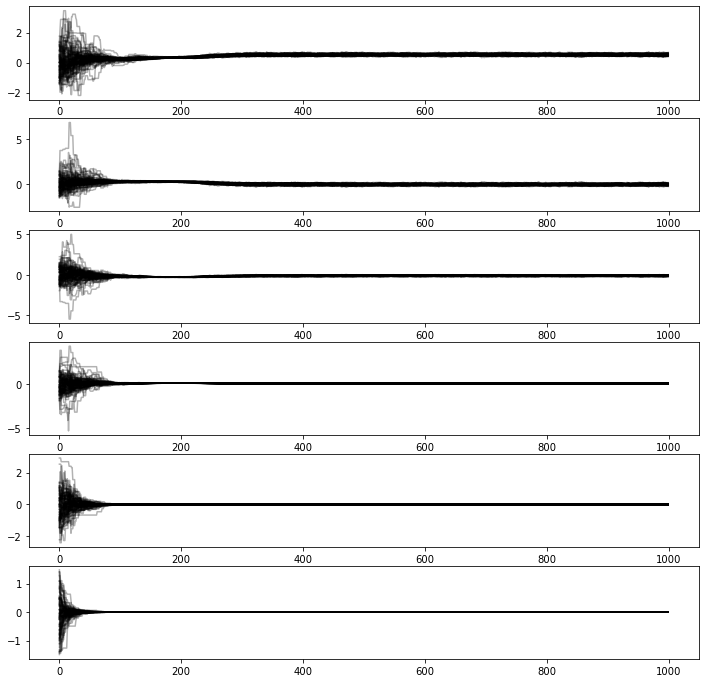

In [14]:
from matplotlib import pyplot as plt

fig = plt.figure()
fig.set_size_inches([12,12])

# Loop through the parameters
for j in range(ndim):
    
    # Add a plot for each parameter
    ax = fig.add_subplot(ndim, 1, j + 1)
    
    # Extract all parallel chains for current parameter
    # This is a 2D array of shape (nWalkers, nSteps). We need to 
    # transpose the array for it to be plotted step on x-axis
    chains = sampler.chain[:,:,j].transpose()
    #chains = sampler.chain[:,:100,j].transpose() #CAN BLOW UP THE FIRST 300 or so STEPS TO HIGHLIGHT THE BURN IN.
    
    # Plot the chains with time/steps on the bottom
    ax.plot(chains, 'k', alpha = 0.3)
    
#plot shows chains for each parameter. Initial steps start at the random intitial estimates, not close to best fit. 
#Can see that the chains "converge" to a value after some time and scatter around that value. Now, the random walk is 
#not exactly random. MCMC does something smarter: it tries to push into regions of higher likelihood and densly sample 
#those regions, and does not spend time in regions where the likelihood is low.

#can also see some corellation between the parameters, e.g., P1 is low, P2 is high. We will explore this corellation
#later.

#note that there is a whole other industry on deciding when things have converged. Here we are doing by looking at the
#chains, but you can imagine that this manual intervention is not ideal when you need to do many fits.

There is a nice version of this function in the file ```Imports/util_tute04.py```, so you can use that in future. This function plots the samples as points, coloured by likelihood.

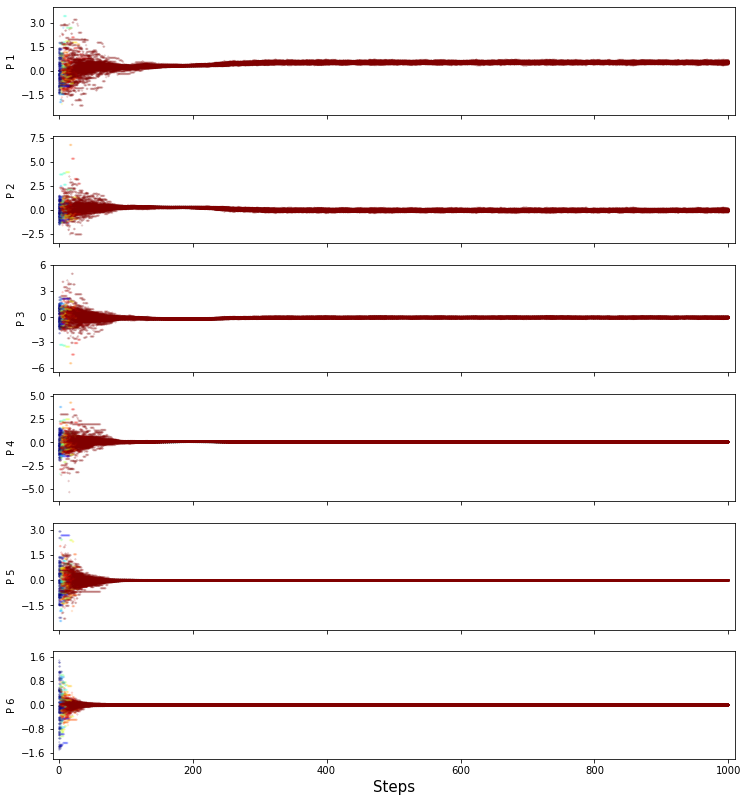

In [15]:
# Import the plotting function and exceute
from Imports.util_tute04 import plot_trace
plot_trace(sampler)

Depending on your initial values, most chains have settled down to a flat (but finitely thick) trace. If they have not then you should run the burn-in for more steps.

Now we want to run the sampler again, but initializing each walker with the converged values, that is, the values on the extreme right of the plot above. These are stored in the ```pos``` variable from the last run of the sampler.

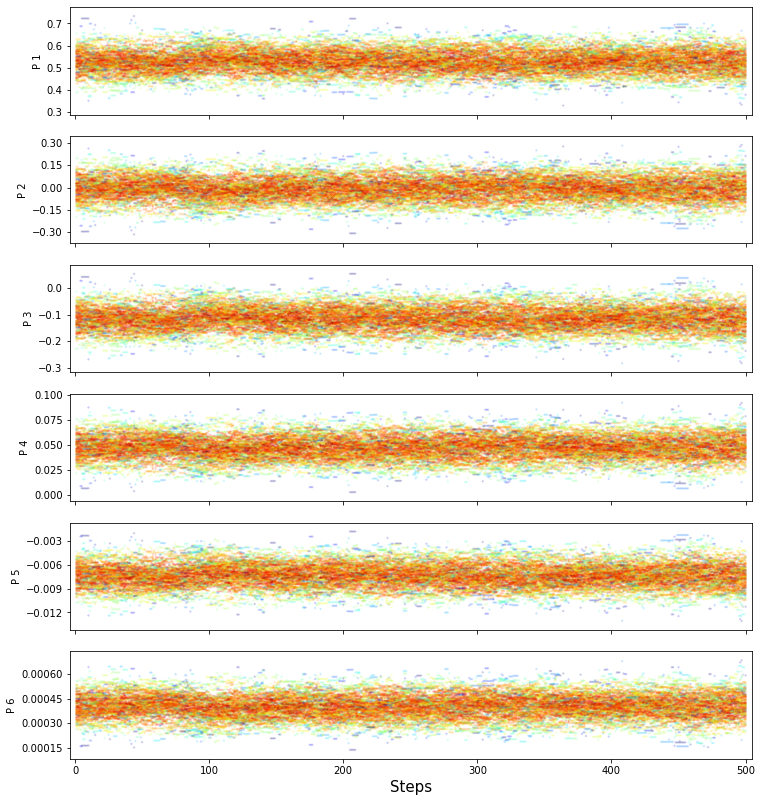

In [16]:
# Run the sampler again from the final burn-in position
nSteps = 500
sampler.reset()      # NB: you must reset the history
pos, prob, state = sampler.run_mcmc(pos0       = pos,  # <- NB
                                    N          = nSteps, 
                                    storechain = True)

# Plot the new trace
plot_trace(sampler)

**Key Point:** 

Looking at a single plot above (e.g., the P1 parameter), we see that the samples are scattered around a single value of ~0.51. A histogram of sampled values is proportional to the *posterior likelihood distribution* of the P1 parameter.

Start by accessing a *flattened* version of the chain: all 100 parallel walker chains merged into one 1D array. Then plot the histogram of the values.

/Users/mq20150564/software/anaconda2/envs/python37/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0, 0.5, 'Sampler Density'), Text(0.5, 0, 'P1 Value')]

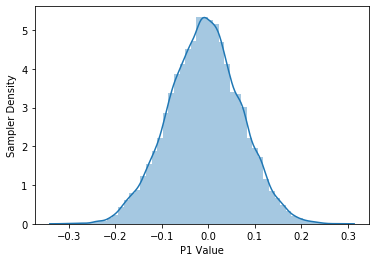

In [17]:
import seaborn as sns

# Access the flattened chain of parameter 1
# The sampler stores a flattened chain as a convenience
# This is just a 1D array of length 100 * 500
fChain1 = sampler.flatchain[:, 1]

# Make a nice looking histogram with seaborne
# Could also use matplotlib plt.hist()

ax = sns.distplot(fChain1, bins=50, kde=True)
ax.set(xlabel='P1 Value', ylabel='Sampler Density')

#from this distribution, we can estimate the best-fitting value (the peak of the distribution),
#as well as the uncertainty on the parameter estimate, which is encapsulated in the spread
# of the distribution. 

Now we can make estimates of the best-fit value and uncertainties using the method described in Tutorial 1.

/Users/mq20150564/software/anaconda2/envs/python37/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


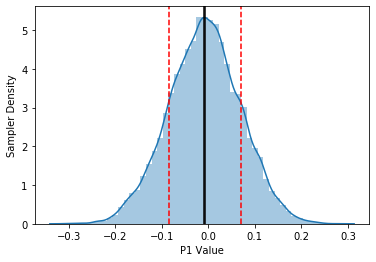

In [18]:
# Use the percentiles function to calculate the crossing points
neg1sig, mean, pos1sig = np.percentile(fChain1, [15.72, 50, 84.27])

# Plot the posterior distribution and values
ax = sns.distplot(fChain1, bins=50, kde=True)
ax.set(xlabel='P1 Value', ylabel='Sampler Density')
ax.axvline(mean, color="k")
ax.axvline(np.mean(fChain1), color="k")
ax.axvline(neg1sig, color="r", linestyle="--")
ax.axvline(pos1sig, color="r", linestyle="--")

We can also visualise how each parameter is correlated with every other parameter. Let's try checking how the polynomial coefficent P6 is correlated with P1:

Text(0, 0.5, 'P1 Value')

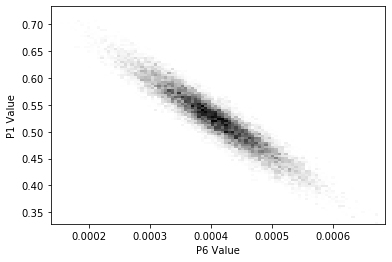

In [19]:
# Access the chains
# Order is ["P1", "P2", "P3", "P4", "P5", "P6"]
fChain1 = sampler.flatchain[:, 0]
fChain6 = sampler.flatchain[:, 5]

# Make a 2D histogram
nXY, xBins, yBins = np.histogram2d(x=fChain6, y=fChain1, bins=100)
plt.pcolor(xBins, yBins, nXY, cmap="gray_r")

# Label the figure
plt.xlabel("P6 Value")
plt.ylabel("P1 Value")

Here we can see the P6 is anti-correlated with P1: solutions with higher values of P6 drive the P1 value down. 

Rather than making these plots by hand, there is a module called ```corner``` that is dedicated to plotting the results of MCMC samplers and similar. 

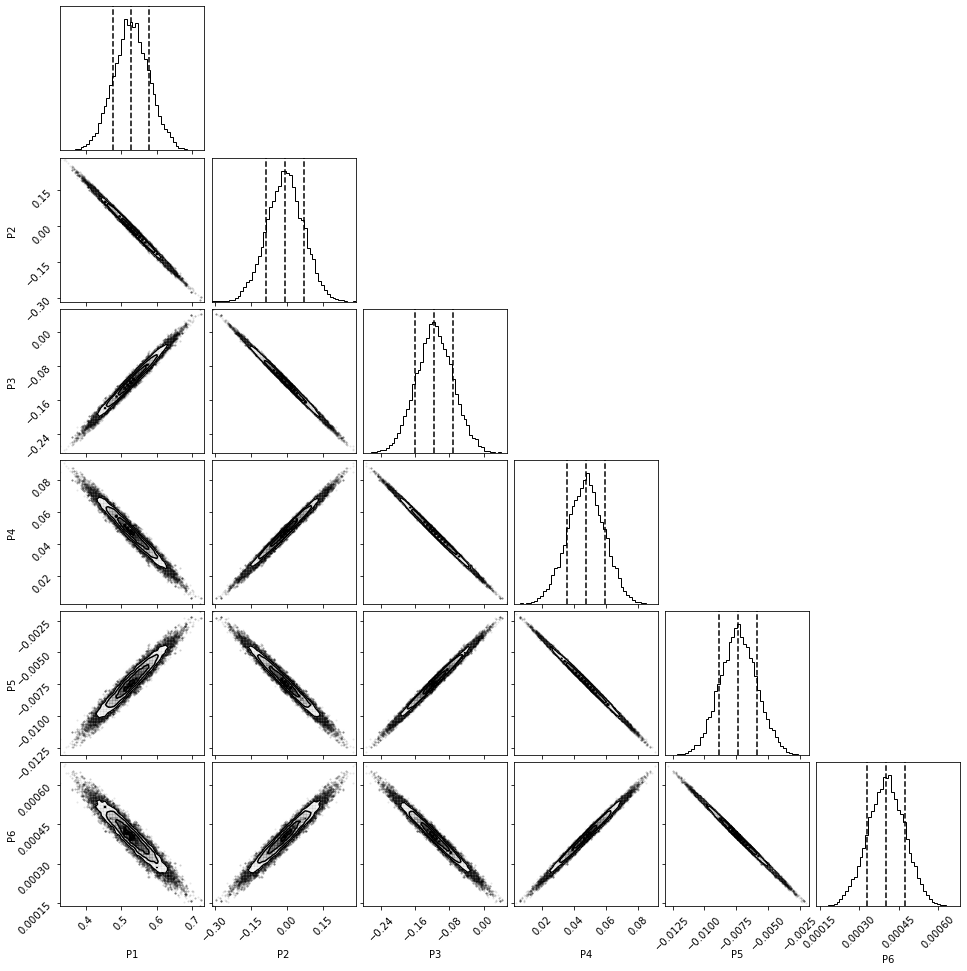

In [20]:
from Imports import corner

# Make a labeled corner figure
cornerFig = corner.corner(xs=sampler.flatchain,
                          bins=50,
                          labels=["P1", "P2", "P3", "P4", "P5", "P6"],
                          verbose=False,
                          quantiles=[0.1572, 0.5, 0.8427])

At this point we should calculate the best-fitting results and plot the model over the data as a visual check.

P1 = 0.5276 (+0.0510703, -0.0514548)
P1 = 0.5281 (+/-0.0507413)
P2 = -0.007658 (+0.077766, -0.0775557)
P2 = -0.008275 (+/-0.0771134)
P3 = -0.1153 (+0.0442963, -0.0441686)
P3 = -0.1149 (+/-0.0438202)
P4 = 0.04728 (+0.0117689, -0.0117437)
P4 = 0.04717 (+/-0.0116681)
P5 = -0.00734 (+0.00147964, -0.00147671)
P5 = -0.007332 (+/-0.00147252)
P6 = 0.0004031 (+7.14374e-05, -7.08355e-05)
P6 = 0.0004028 (+/-7.12065e-05)


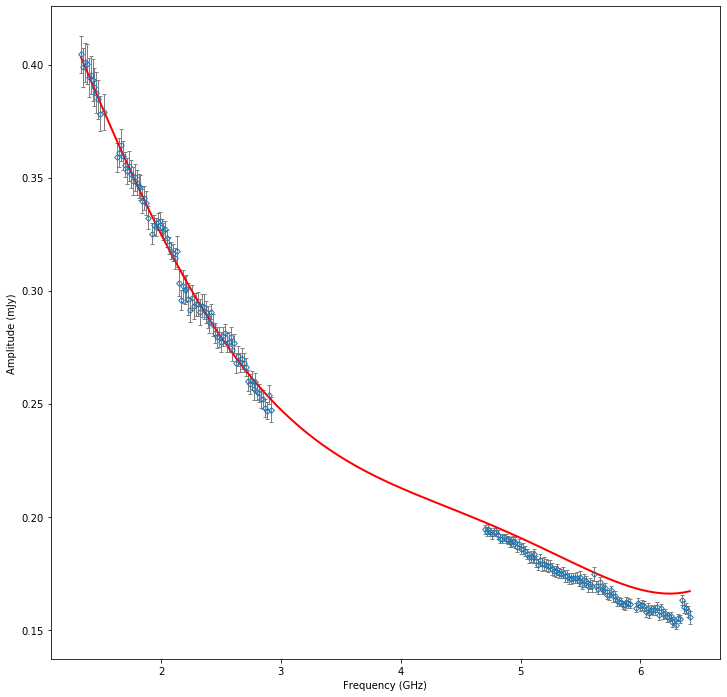

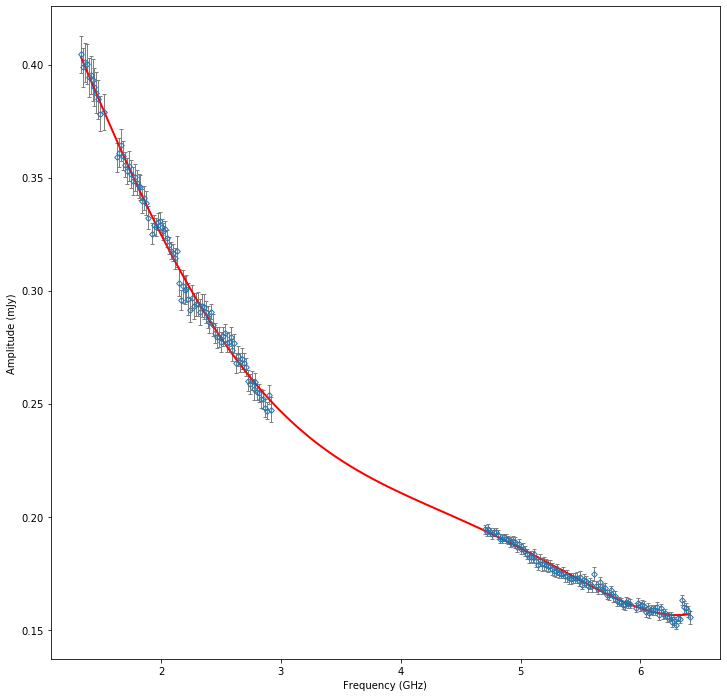

In [21]:
#corner gives a nice visualisation of how parameters corellate with one another, 
#but we need to loop over the parameters to determine the best fit values and their
#uncertainties.
import scipy.stats as stats
# Loop over the free parameters
pBest = []
pBest_mean=[]
labels = ["P1", "P2", "P3", "P4", "P5", "P6"]
for i in range(ndim):
    
    # Access the chain for the current parameter
    fChain = sampler.flatchain[:, i]
    
    # Work out the best fit value (mean) and +/- 1-sigma values using percentiles.
    neg1sig, median, pos1sig = np.percentile(fChain, [15.72, 50.0, 84.27])
    pBest.append(median)
    # Calculate the uncertainties:
    errLow = median - neg1sig
    errHigh = pos1sig - median
    # Print the results
    print("{} = {:.4g} (+{:3g}, -{:3g})"
          .format(labels[i], median, errLow, errHigh))
    
    #if our distributions look like nice and symmetric Gaussians, we can also use
    #the mean and standard deviations as summary statistics
    mean=np.nanmean(fChain)
    err=np.nanstd(fChain)
    pBest_mean.append(mean)
    # Print the results
    print("{} = {:.4g} (+/-{:3g})"
          .format(labels[i], mean, err))
    
    
# Plot the results
plot_spec_polyN(xData, yData, dyData, pBest)
plot_spec_polyN(xData, yData, dyData, pBest_mean)

#Interestingly, the fit looks pretty bad when using only 500 steps in the final MCMC run. I think this 
#has to do with the fact that the 50th percentile (AKA the median) measures are slightly noisy for this 
#number of bins. I increased the number of steps in the final MCMC run above to 5000 in order to measure a more
#precese median/mean. The standard error on the mean of a Gaussian distribution is err=sigma/sqrt(N)
#where N is the sample size, sigma the standard deviation. For the median, the rule of thumb is that
# the standard error on the median is 1.25 times that of the standard error on the mean. So, increasing
#N decreases the uncertainnty on the measured mean/median. Moreover, using the mean in place
#of the median produces much better results even for the smaller number of steps.


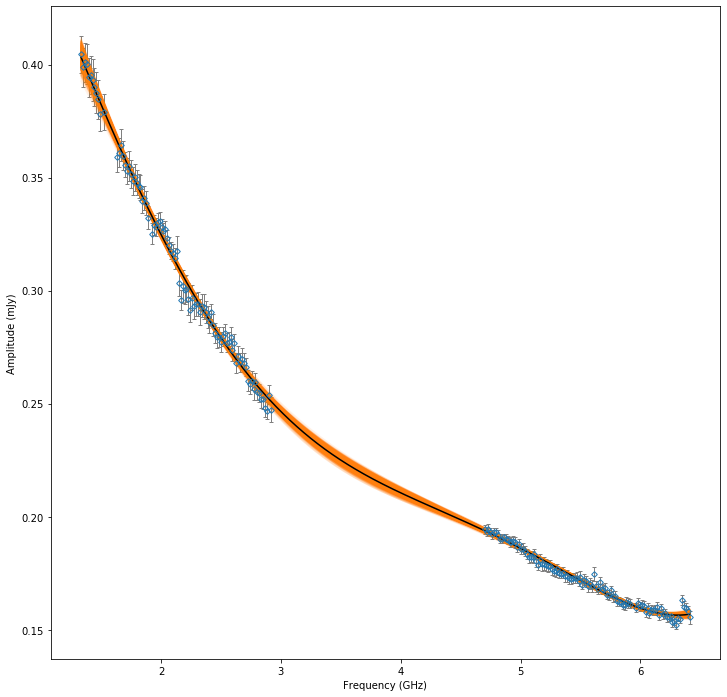

In [23]:
#can also visualise the uncertainties in the model by overplotting a number of samples from the chain:
Flat_Chain=sampler.flatchain

rand_ind=np.random.randint(len(sampler.flatchain[:,0]),size=1000)#generate 1000 random integers in the range 0-50000
#plot the data
plt.figure(figsize=[12,12])
plt.errorbar(x=xData, y=yData, yerr=dyData, mfc="none",
                ms=4, fmt="D", ecolor="grey", label="Data",
                elinewidth=1.0, capsize=2)
plt.xlabel('Frequency (GHz)')
plt.ylabel('Amplitude (mJy)')
#set up xModel
nSamples = 5000
xModel = np.linspace(start=np.min(xData),
                     stop=np.max(xData),
                     num=nSamples)
#loop over random flatchains and plot the model derived from the 
#parameters at the given chain
for i in rand_ind:#np.arange(len(Flat_Chain[:,0])):#
    yModel = polyN(Flat_Chain[i,:],xModel)
    plt.plot(xModel,yModel,"C1",alpha=0.1)
    #print('pBest =',pBest)
    #print('Chain ',i,' params= ',Flat_Chain[i,:])
#compare with the best fit from the mean of the parameter distributions
yModel = polyN(np.array(pBest_mean),xModel)
plt.plot(xModel,yModel,"k")#overplots in black
